# Problem:
In this project, we delve deep into the thriving sector of online retail by analyzing a transactional dataset from a UK-based retailer, available at the UCI Machine Learning Repository(https://archive.ics.uci.edu/dataset/352/online+retail). This dataset documents all transactions between 2010 and 2011. Our primary objective is to amplify the efficiency of marketing strategies and boost sales through customer segmentation. We aim to transform the transactional data into a customer-centric dataset by creating new features that will facilitate the segmentation of customers into distinct groups using the K-means clustering algorithm. This segmentation will allow us to understand the distinct profiles and preferences of different customer groups. Building upon this, we intend to develop a recommendation system that will suggest top-selling products to customers within each segment who haven't purchased those items yet, ultimately enhancing marketing efficacy and fostering increased sales.

# Objectives:
Data Cleaning & Transformation: Clean the dataset by handling missing values, duplicates, and outliers, preparing it for effective clustering.

In [1]:
import sklearn
print(sklearn.__version__)

1.0


In [ ]:
#pip install scikit-learn==1.0.0

In [2]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [ ]:
import sys
print(sys.executable)

In [ ]:
#pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
X = online_retail.data.features 
y = online_retail.data.targets 
  
# metadata 
print(online_retail.metadata) 
  
# variable information 
print(online_retail.variables) 

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline
print('imports done...')

imports done...


In [9]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [10]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [ ]:
import os
print(os.getcwd())
cwd=os.getcwd()

In [15]:
#df=pd.read_csv('https://archive.ics.uci.edu/static/public/352/data.csv')
df = pd.read_csv(cwd + '/online_retail_data.csv', encoding="ISO-8859-1")

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Dataset Description:
Variable	Description
InvoiceNo	Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode	Code uniquely assigned to each distinct product.
Description	Description of each product.
Quantity	The number of units of a product in a transaction.
InvoiceDate	The date and time of the transaction.
UnitPrice	The unit price of the product in sterling.
CustomerID	Identifier uniquely assigned to each customer.
Country	The country of the customer.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


From the dataset information we see Description field has some missing values (540455/541909 are populated) but CustomerID field has more missing values (406829/541909)

InvoiceDate field is in datetime format which will help in time series analysis.
Also we can see, a single customer (CustomerID) can have multiple transactions

in next steps, data cleaning, handling missing values, handle erroneous data, filter outliers that will help us create new features to acheive our objective or project goals

In [21]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [22]:
# Summary statistics for Categorical variables
df.describe(include=object).T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Inferences from statistical summary of numerical variables (Quantity, UnitPrice,CustomerID) and categorical variables(InvoiceNo,StockCode,Description,InvoiceDate,Country) :

Quantity: 
Average quantity is 9.55(mean of quantity), 
Standar deviation of 218 from mean 9.55 is very huge which means data is wide spread, 
There is much difference between 75%(10) and max(80995) indicating the presence of outliers in Quantity field of the dataset. Max and min are 80995, -80995 implying large purchase/returns.

UnitPrice:
The average unit price of the products is approximately 4.61.
The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.
Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

CustomerID:
There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.
The Customer IDs range from 12346 to 18287, helping in identifying unique customers.

InvoiceNo:
There are 25900 unique invoice numbers, indicating 25900 separate transactions.
The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.

StockCode:
Overall there are 4070 items that are purchased in the period.
85123A	product/item or stock code is the most frequently purchased item ie., 2313 times

Description:
There are 4223 unique product descriptions.
The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.
There are some missing values(541909 - 540455 = 1454 transactions which do not have product description)  in this column which need to be treated.

Country:
The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) [(495478/541909) * 100 = 91.4% ] originating from the United Kingdom.

# Data cleansing and Transformations
This process addresses missing values, eliminating duplicate entries, correcting anomalies in product codes and descriptions, and other necessary adjustments to prepare the data for in-depth analysis and modeling.

index:: Index(['Description', 'CustomerID'], dtype='object')


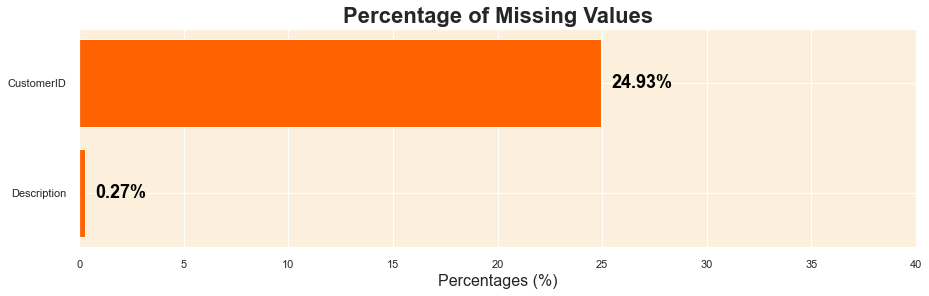

In [35]:
#Handling missing values:

#determine the percentage of missing values present in each column
#select a strategy to address the missing values



# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)


# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Handling Missing Values Strategy:
CustomerID (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

Description (0.27% missing values)

The Description column has a minor percentage of missing values. However, it has been noticed that there are inconsistencies in the data where the same StockCode does not always have the same Description. This indicates data quality issues and potential errors in the product descriptions.

Given these inconsistencies, imputing the missing descriptions based on StockCode might not be reliable. Moreover, since the missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.

In [36]:
df[df['CustomerID'].isnull()|df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [39]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df=df.dropna(subset=['CustomerID','Description'])


In [40]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

In [42]:
#Handling Duplicates

# Finding duplicate rows (keeping all instances)
duplicate_rows=df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

# The entire rows are duplicated which means it could be data error. So, remove the duplicate records and keep only one instance of the duplicate records

# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

#remove the full row duplicates
df.drop_duplicates(inplace=True)

# Getting the number of rows in the dataframe
df.shape[0]

The dataset contains 5225 duplicate rows that need to be removed.


401604

In [43]:
# Treating Cancelled Transactions

# To refine our understanding of customer behavior and preferences, 
# we need to take into account the transactions that were cancelled. 
# Initially, we will identify these transactions by filtering the rows 
# where the InvoiceNo starts with "C". 
# Subsequently, we will analyze these rows to understand their common characteristics or patterns:

# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'),'Cancelled','Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Inferences from the Cancelled Transactions Data:
All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.
The UnitPrice column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.

Strategy for Handling Cancelled Transactions:
Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.
Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.

In [44]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


In [46]:
#Correcting StockCode Anomalies

#plot the top 10 most frequent stock codes along with their percentage frequency:

unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

3684
The number of unique stock codes in the dataset is: 3684


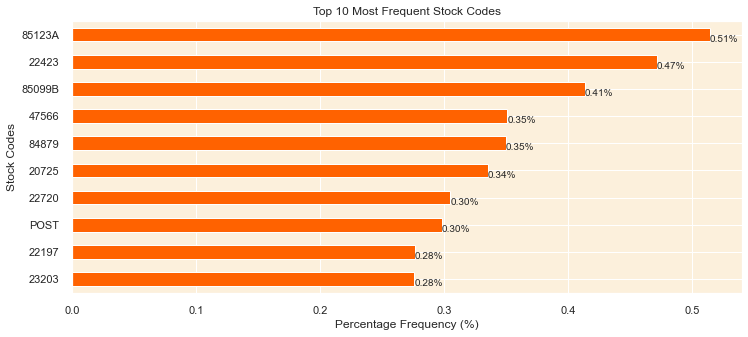

In [48]:

# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12,5))
top_10_stock_codes.plot(kind='barh',color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

Inferences on Stock Codes:

Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.

Popular Items: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [49]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


Inference:
The output indicates the following:

A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.

There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.
Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:

In [50]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


Let's calculate the percentage of records with these anomalous stock codes:

In [51]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


Inference:¶
Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.

Strategy:
Given the context of the project, where the aim is to cluster customers based on their product purchasing behaviors and develop a product recommendation system, it would be prudent to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions, which would lead to a more accurate and meaningful analysis.

Thus, the strategy would be to filter out and remove rows with these anomalous stock codes from the dataset before proceeding with further analysis and model development:

In [52]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [53]:
# Getting the number of rows in the dataframe
df.shape[0]

399689

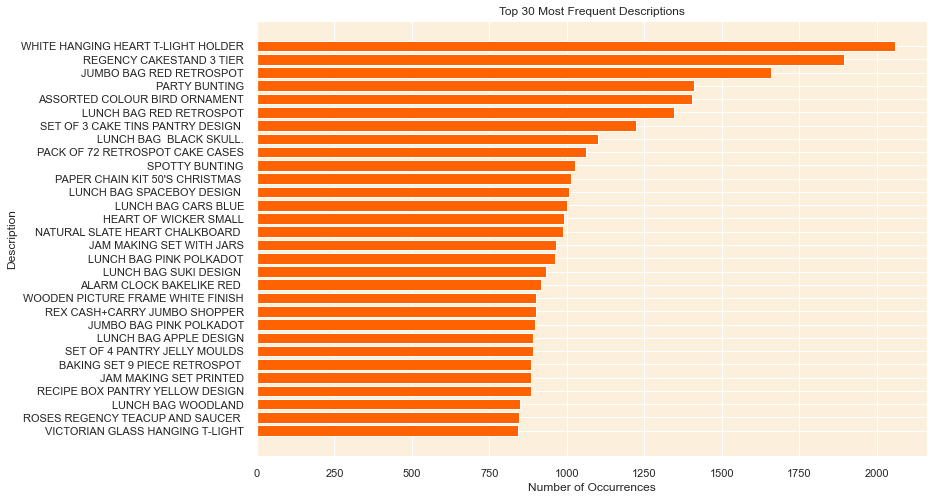

In [54]:
#Cleaning Description Column

#First, I will calculate the occurrence count of each unique description in the dataset. Then, I will plot the top 30 descriptions. This visualization will give a clear view of the highest occurring descriptions in the dataset:

# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()
    

Inferences on Descriptions:
The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [55]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Inference:
Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

Strategy:
Step 1: Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build.
Step 2: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.
By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [56]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [57]:
# Getting the number of rows in the dataframe
df.shape[0]

399606

In [58]:
#Treating Zero Unit Prices

df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

Inference:
The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [59]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


Inferences on UnitPrice: 
The transactions with a unit price of zero are relatively few in number (33 transactions).
These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.
Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

Strategy: 
Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system.

In [60]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [61]:
#Outlier Treatment

# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [62]:
# Getting the number of rows in the dataframe
df.shape[0]

399573